Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 4
Erster Timestamp: 2026-01-01 00:00:00
Letzter Timestamp: 2026-01-08 23:45:00
Simulationshorizont: 8 Tage
Kalenderische Tage je Tagtyp:
- working_day: 4 Tage
- saturday: 1 Tage
- sunday_holiday: 3 Tage

Anzahl Ladesessions im Simulationshorizont: 109
Max. gleichzeitig ladende Fahrzeuge: 4

Beispiel-Sessions (erste 10):
Fahrzeug: Mokka e, Ankunft: 2026-01-02 06:57:02.375802, Abfahrt: 2026-01-02 14:23:48.441204, Kapazität: 50.0 kWh, geladene Energie: 5.0 kWh, Restbedarf: 0.0 kWh
Fahrzeug: 1# Pro Plus, Ankunft: 2026-01-02 07:09:03.455651, Abfahrt: 2026-01-02 13:24:13.984745, Kapazität: 66.0 kWh, geladene Energie: 17.9 kWh, Restbedarf: 0.0 kWh
Fahrzeug: EQA, Ankunft: 2026-01-02 07:23:52.682713, Abfahrt: 2026-01-02 10:44:17.872276, Kapazität: 70.0 kWh, geladene Energie: 7.0 kWh, Restbedarf: 0.0 kWh
Fahrzeug: ID.4 Pro S, Ankunft: 2026-01-02 07:42:00.552875, Abfahrt: 2026-01-02 15:58:39.591560, Kapazität: 77.0 kWh, geladene Ener

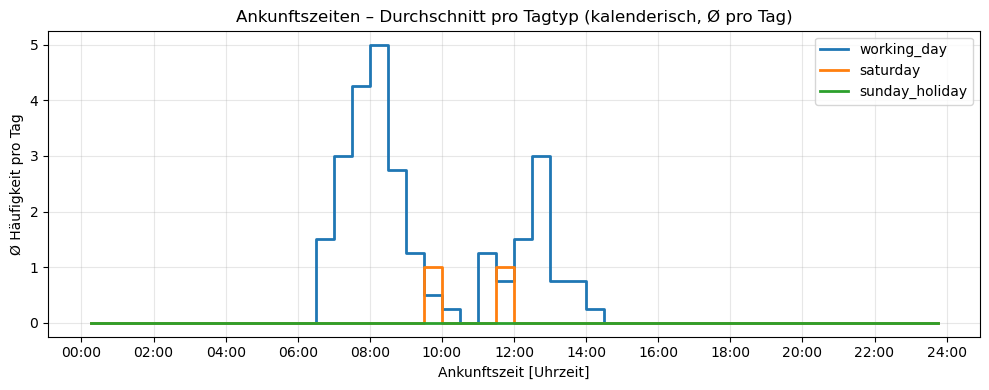

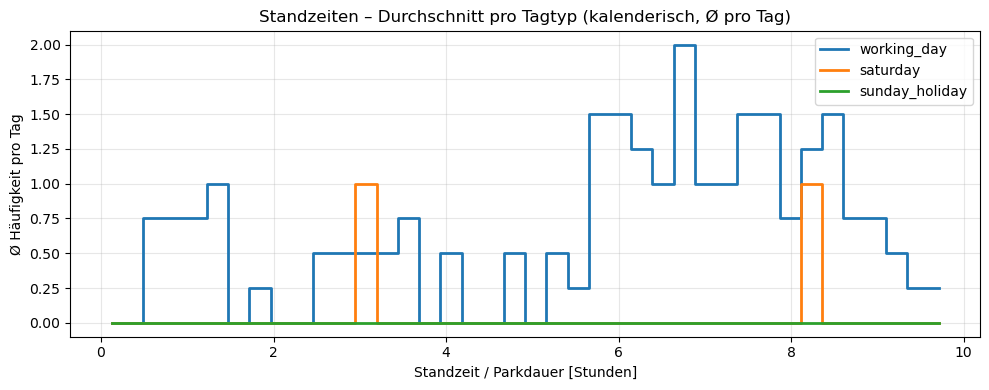

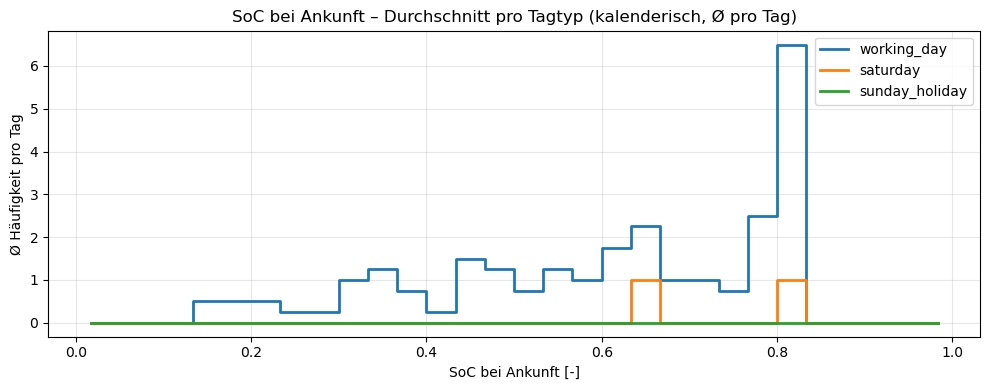

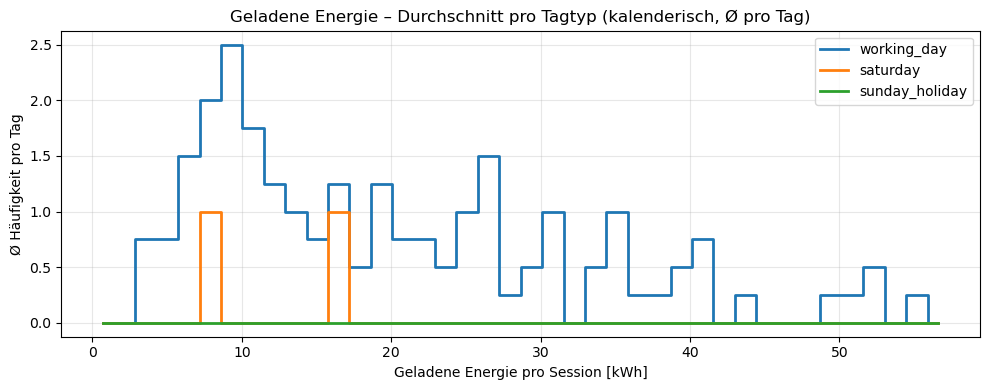

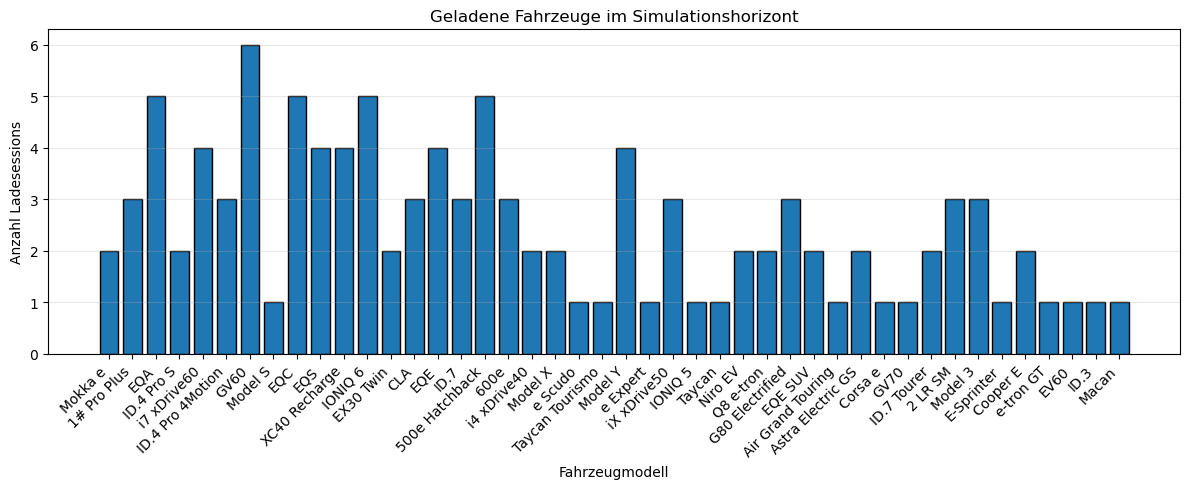

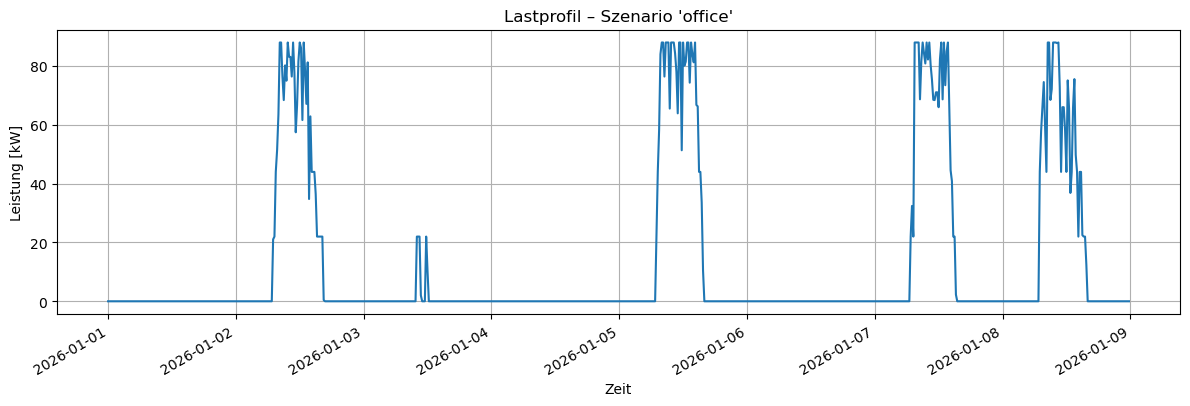

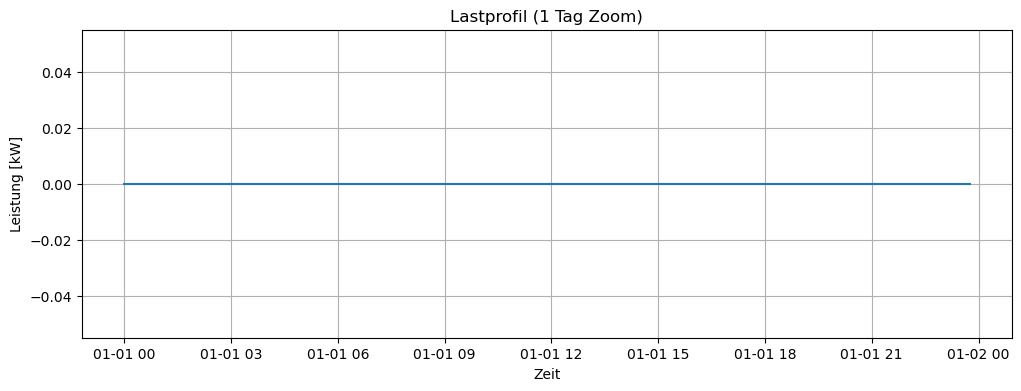

In [36]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta, date

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    load_vehicle_profiles_from_csv,
)

# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "office"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions, charging_counts = simulate_load_profile(scenario)

# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

# ---------------------------------------------------------------------
# Day-Type-Logik lokal im Notebook
# ---------------------------------------------------------------------
def determine_day_type_notebook(dt, holiday_dates):
    d = dt.date()
    if d in holiday_dates:
        return "sunday_holiday"
    wd = dt.weekday()  # Mo=0 ... So=6
    if wd == 6:
        return "sunday_holiday"
    if wd == 5:
        return "saturday"
    return "working_day"

# ---------------------------------------------------------------------
# Feature-Helper pro Session
# ---------------------------------------------------------------------
def minutes_since_midnight(dt):
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s):
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s):
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s):
    return float(s["soc_arrival"])

def feat_delivered_kwh(s):
    return float(s.get("delivered_energy_kwh", 0.0))

# ---------------------------------------------------------------------
# Tage NICHT aus Sessions zählen, sondern kalendarisch
#   -> verhindert Schwankungen, wenn an einem Feiertag zufällig 0 Sessions entstehen
# ---------------------------------------------------------------------
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

all_days = [start_dt.date() + timedelta(days=i) for i in range(horizon_days)]

days_by_type_calendar = defaultdict(list)
for d in all_days:
    dt_midday = datetime(d.year, d.month, d.day, 12, 0)  # sicher innerhalb des Tages
    day_type = determine_day_type_notebook(dt_midday, holiday_dates)
    days_by_type_calendar[day_type].append(d)

print("Kalenderische Tage je Tagtyp:")
for k in ["working_day", "saturday", "sunday_holiday"]:
    print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")

# ---------------------------------------------------------------------------
# Kontrollen: Anzahl Sessions und Beispiel-Sessions
# ---------------------------------------------------------------------------
print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("Max. gleichzeitig ladende Fahrzeuge:", max(charging_counts))

print("\nBeispiel-Sessions (erste 10):")


for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "      #NEU
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"           # NEU
    )

# ---------------------------------------------------------------------
# Sessions nach Datum gruppieren (für Histogramme pro Tag)
#   (Tage ohne Sessions bleiben einfach leere Listen)
# ---------------------------------------------------------------------
sessions_by_day = defaultdict(list)  # key: date -> list[session]
for s in sessions:
    sessions_by_day[s["arrival_time"].date()].append(s)

# ---------------------------------------------------------------------
# Kern: Durchschnitts-Histogramm pro Tagtyp (Ø pro Tag, inkl. 0-Sessions-Tage)
# ---------------------------------------------------------------------
def average_hist_per_daytype_calendar(
    daytype_to_days: dict[str, list[date]],
    sessions_by_day: dict[date, list],
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    """
    Für jeden Tagtyp:
      - iteriere über ALLE kalendarischen Tage dieses Typs
      - pro Tag: Histogramm (Counts) berechnen
      - über alle Tage mitteln => Ø Counts pro Tag (je Bin)

    Vorteil:
      - Tage ohne Sessions gehen als 0 in den Mittelwert ein
      - Anzahl Tage ist deterministisch (keine Schwankung)
    """
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type

def plot_avg_hist_overlay(avg_counts_by_type, bin_edges, xlabel, title, xticks=None, xtick_labels=None):
    plt.figure(figsize=(10, 4))

    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# Ankunftszeiten: 0..24h, 30-Min-Bins
# ---------------------------------------------------------------------
arrival_bin_edges = np.linspace(0, 24, 49)  # 48 bins à 0.5h

avg_arrival = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_arrival_hours,
    bin_edges=arrival_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_arrival,
    bin_edges=arrival_bin_edges,
    xlabel="Ankunftszeit [Uhrzeit]",
    title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
    xticks=list(range(0, 25, 2)),
    xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
)

# ---------------------------------------------------------------------
# Standzeiten: datengetriebene Obergrenze (p99), Stunden
# ---------------------------------------------------------------------
all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
max_p = np.percentile(all_parking, 99) if len(all_parking) else 1.0
max_p = max(max_p, 0.5)  # kleine Untergrenze, falls sehr wenig Daten
parking_bin_edges = np.linspace(0, max_p, 41)  # 40 bins

avg_parking = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_parking_hours,
    bin_edges=parking_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_parking,
    bin_edges=parking_bin_edges,
    xlabel="Standzeit / Parkdauer [Stunden]",
    title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)

# ---------------------------------------------------------------------
# SoC bei Ankunft: 0..1
# ---------------------------------------------------------------------
soc_bin_edges = np.linspace(0, 1, 31)  # 30 bins

avg_soc = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_soc_arrival,
    bin_edges=soc_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_soc,
    bin_edges=soc_bin_edges,
    xlabel="SoC bei Ankunft [-]",
    title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)

# ---------------------------------------------------------------------
# Geladene Energie: datengetriebene Obergrenze (p99), kWh
# ---------------------------------------------------------------------
all_energy = np.array([feat_delivered_kwh(s) for s in sessions], dtype=float)
max_e = np.percentile(all_energy, 99) if len(all_energy) else 1.0
max_e = max(max_e, 1.0)  # Untergrenze
energy_bin_edges = np.linspace(0, max_e, 41)  # 40 bins

avg_energy = average_hist_per_daytype_calendar(
    daytype_to_days=days_by_type_calendar,
    sessions_by_day=sessions_by_day,
    value_fn=feat_delivered_kwh,
    bin_edges=energy_bin_edges,
)

plot_avg_hist_overlay(
    avg_counts_by_type=avg_energy,
    bin_edges=energy_bin_edges,
    xlabel="Geladene Energie pro Session [kWh]",
    title="Geladene Energie – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
)

# ---------------------------------------------------------------------------
# Auswertung: welche Fahrzeuge wurden wie oft geladen? (Diagramm)
# ---------------------------------------------------------------------------
vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

# Sortieren nach Häufigkeit (absteigend)
models = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(12, 5))
plt.bar(models, values, edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions")
plt.title("Geladene Fahrzeuge im Simulationshorizont")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# ---------------------------------------------------------------------------
# Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

steps_per_day = int(24*60/scenario["time_resolution_min"])

plt.figure(figsize=(12,4))
plt.plot(timestamps[:steps_per_day], load_kw[:steps_per_day])
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title("Lastprofil (1 Tag Zoom)")
plt.grid(True)
plt.show()

